<a href="https://colab.research.google.com/github/SauloHenriqueAguiar/DeepLearningCNN/blob/main/tranferlearningPyTorchAbelhasFormigas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
%matplotlib inline

In [14]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Le os dados
---------

Usaremos os pacotes torchvision e torch.utils.data para carregar o
dados.

O problema que vamos resolver hoje é treinar um modelo para classificar
** formigas ** e ** abelhas **. Temos cerca de 120 imagens de treinamento para formigas e abelhas.
Existem 75 imagens de validação para cada classe. Normalmente, este é um muito
pequeno conjunto de dados para generalizar, se treinado do zero. Desde que nós
estamos usando a aprendizagem por transferência, devemos ser capazes de generalizar razoavelmente.


Este conjunto de dados é um subconjunto muito pequeno de imagenet.

Baixe os dados [aqui] (https://download.pytorch.org/tutorial/hymenoptera_data.zip) e extraia-os para o diretório atual.



In [15]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2021-11-27 00:05:37--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.222.158.75, 52.222.158.70, 52.222.158.43, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.222.158.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.1’

hymenoptera_data.zi 100%[===================>]  45.10M   123MB/s    in 0.4s    

2021-11-27 00:05:38 (123 MB/s) - ‘hymenoptera_data.zip.1’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/11657

In [16]:
# Data augmentation and Normalização  para treinamento
# Apenas normalização para validação
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Vizualiza algumas imagens
----------------------

Vamos visualizar algumas imagens de treinamento para entender o data augmentation.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


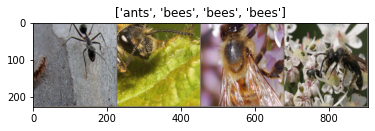

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pare um pouco para que os gráficos sejam atualizados


#Obtenha um lote de dados de treinamento
inputs, classes = next(iter(dataloaders['train']))

# Faça uma grade de lote
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Treinando o modelo
------------------

Agora, vamos escrever uma função geral para treinar um modelo.





In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Cada época tem uma fase de treinamento e validação
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Definir o modelo para o modo de treinamento
            else:
                model.eval()   # Defina o modelo para o modo de avaliação

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zera os gradientes do parâmetro
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calling scheduler
                    if phase == 'train':
                        scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizando as previsões do modelo
---------------------------------

Função genérica para exibir previsões para algumas imagens




In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning da convnet
----------------------
Carregue um modelo pré-treinado e redefina a camada final totalmente conectada(fully connected).





In [19]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Treina e Avalia
------------------





In [20]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7637 Acc: 0.5000
val Loss: 0.7265 Acc: 0.5948

Epoch 1/24
----------
train Loss: 0.7320 Acc: 0.5287
val Loss: 0.7005 Acc: 0.5752

Epoch 2/24
----------
train Loss: 0.7225 Acc: 0.5328
val Loss: 0.7227 Acc: 0.5817

Epoch 3/24
----------
train Loss: 0.7192 Acc: 0.5287
val Loss: 0.6958 Acc: 0.5948

Epoch 4/24
----------
train Loss: 0.7381 Acc: 0.5246
val Loss: 0.6954 Acc: 0.5948

Epoch 5/24
----------
train Loss: 0.7333 Acc: 0.5205
val Loss: 0.7116 Acc: 0.5948

Epoch 6/24
----------
train Loss: 0.7175 Acc: 0.5287
val Loss: 0.7134 Acc: 0.6013

Epoch 7/24
----------
train Loss: 0.7396 Acc: 0.5205
val Loss: 0.7082 Acc: 0.5882

Epoch 8/24
----------
train Loss: 0.7356 Acc: 0.5082
val Loss: 0.7144 Acc: 0.6013

Epoch 9/24
----------
train Loss: 0.7309 Acc: 0.5164
val Loss: 0.7132 Acc: 0.6013

Epoch 10/24
----------
train Loss: 0.7390 Acc: 0.5328
val Loss: 0.7037 Acc: 0.5882

Epoch 11/24
----------
train Loss: 0.7279 Acc: 0.5123
val Loss: 0.6812 Acc: 0.6013

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


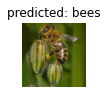

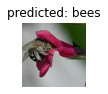

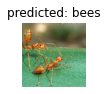

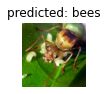

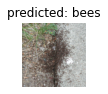

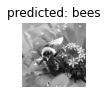

In [21]:
visualize_model(model_ft)

ConvNet como extrator de features 
----------------------------------

Aqui, precisamos congelar toda a rede, exceto a camada final. Nós precisamos
para definir `` requires_grad == False`` para congelar os parâmetros para que o
gradientes não são calculados em `` backward () ``.




In [22]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Treinando e Avaliando
------------------






In [23]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6367 Acc: 0.6475
val Loss: 0.5584 Acc: 0.7451

Epoch 1/24
----------
train Loss: 0.6224 Acc: 0.6270
val Loss: 0.5521 Acc: 0.7451

Epoch 2/24
----------
train Loss: 0.6412 Acc: 0.6189
val Loss: 0.5552 Acc: 0.7516

Epoch 3/24
----------
train Loss: 0.6422 Acc: 0.6352
val Loss: 0.5531 Acc: 0.7386

Epoch 4/24
----------
train Loss: 0.6454 Acc: 0.5984
val Loss: 0.5601 Acc: 0.7190

Epoch 5/24
----------
train Loss: 0.6329 Acc: 0.6762
val Loss: 0.5675 Acc: 0.7516

Epoch 6/24
----------
train Loss: 0.6370 Acc: 0.6311
val Loss: 0.5668 Acc: 0.7320

Epoch 7/24
----------
train Loss: 0.6331 Acc: 0.6516
val Loss: 0.5702 Acc: 0.7255

Epoch 8/24
----------
train Loss: 0.6209 Acc: 0.6721
val Loss: 0.5510 Acc: 0.7451

Epoch 9/24
----------
train Loss: 0.6166 Acc: 0.7213
val Loss: 0.5546 Acc: 0.7516

Epoch 10/24
----------
train Loss: 0.6320 Acc: 0.6352
val Loss: 0.5664 Acc: 0.7451

Epoch 11/24
----------
train Loss: 0.6318 Acc: 0.6475
val Loss: 0.5522 Acc: 0.7255

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


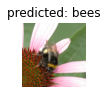

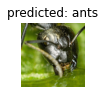

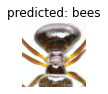

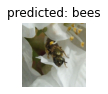

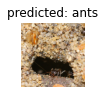

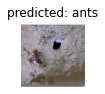

In [24]:
visualize_model(model_conv)

plt.ioff()
plt.show()